In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 
import itertools

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results_1'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, fixed_target = next(iter(test_loader))
lr = 0.0001
latent_size = 10
EPS = 1e-15

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1,
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding,
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, **optim_params):
        super(Encoder, self).__init__()

        self.latent_size = latent_size
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)

        self.fce = FullyConnected([32 * 2 * 2, latent_size * 2])     
            
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1

    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32 * 2 * 2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar

    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        return h

    def _sample(self, n):
        return torch.randn([n, self.latent_size])

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, **optim_params):
        super(Decoder, self).__init__()

        self.latent_size = latent_size
        self.fcd = FullyConnected([latent_size, 32 * 2 * 2])

        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())

    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x

    def forward(self, x):
        return self.decode(x)

    def loss(self, output, target, size_average=True):
        return F.mse_loss(output, target, size_average=size_average)

In [21]:
discriminator = FullyConnected([latent_size, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

[Epoch 1/50] [Batch 0/50000] [D loss: 0.269886] [G loss: 0.092818]
[Epoch 1/50] [Batch 200/50000] [D loss: 0.201486] [G loss: 0.091839]
[Epoch 1/50] [Batch 400/50000] [D loss: 0.283815] [G loss: 0.090951]
[Epoch 1/50] [Batch 600/50000] [D loss: 0.171757] [G loss: 0.105539]
[Epoch 1/50] [Batch 800/50000] [D loss: 0.314693] [G loss: 0.088671]


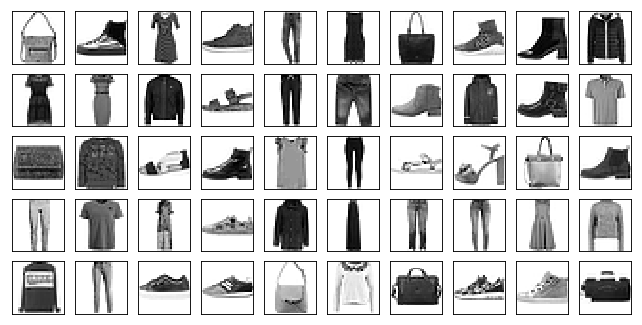

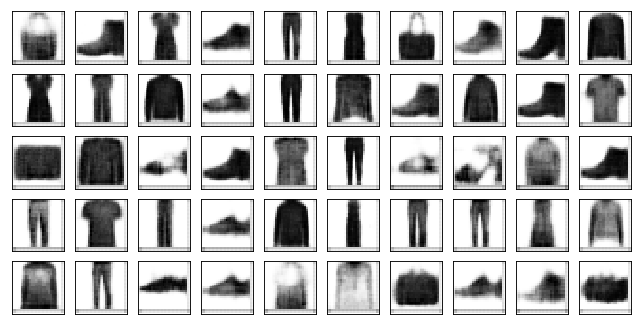

[Epoch 2/50] [Batch 0/50000] [D loss: 0.118445] [G loss: 0.089597]


In [ ]:
def train(epoch):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader): 
        
        valid = torch.Tensor(data.shape[0], 1).fill_(1.0)
        fake = torch.Tensor(data.shape[0], 1).fill_(0.0)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        encoded_imgs = encoder(data)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * F.binary_cross_entropy_with_logits(discriminator(encoded_imgs), valid) + \
                 0.999 * decoder.loss(decoded_imgs, data)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        z = torch.Tensor(np.random.normal(0, 1, (data.shape[0], latent_size)))
        real_loss = F.binary_cross_entropy_with_logits(discriminator(z), valid)
        fake_loss = F.binary_cross_entropy_with_logits(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        if batch_idx % 200 == 0:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, 50, batch_idx, train_size,
                                                            d_loss.item(), g_loss.item()))


def test(loader, epoch):
    imgs = torch.cat([data for data, _ in loader][:1:])
    with torch.no_grad():
        fixed_gen = decoder(encoder(imgs)).data.numpy().reshape(50, 1, 28, 28)
        plot_mnist(imgs, (5, 10), True)
        plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)

for epoch in range(1, 31):
    train(epoch)
    test(valid_loader, epoch)